## Process for PlanetScope Image download.

Considerations:

 1. The image was ready downloaded from the PlanetScope repository and uploaded to Google Cloud Earth Engine Asset.
 2. This was done to avoid the high time in calculating the indexes it is more efficient to do this using geemap and/or python.

In [6]:
# Import the libraries
import geemap
import ee
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [7]:
ee.Authenticate() 

True

In [8]:
ee.Initialize()

In [9]:
#Nota: Acá debemos dibujar un área de interés. Sino en adelante nos fallará el código.

Map = geemap.Map(center = (11.2114, -15.1915), zoom = 12)
Map

Map(center=[11.2114, -15.1915], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [10]:
# Asegurarnos de la creación de una geometría / Por si no la crearon en el mapa anterior.
geometry = ee.Geometry.Polygon([[[-15.21471, 11.188674],
   [-15.21471, 11.222857],
   [-15.133365, 11.222857],
   [-15.133365, 11.188674],
   [-15.21471, 11.188674]]])

In [13]:
#@title GEE index's
collection = ee.ImageCollection("projects/planetscopejesus/assets/Datos_Gabo")

texture = ee.ImageCollection("projects/planetscopejesus/assets/Texture_cafine")
pca = ee.Image('projects/planetscopejesus/assets/pca_cafine').float()

collection = collection.filterDate('2022-05-01', '2022-05-30').filterBounds(geometry) 

# This function maps spectral indices for salinity Mapping using PlanetScope Imagery
def addIndices(img):
  # NDVI
  NDVI = img.normalizedDifference(['b8','b6']).rename('NDVI')
  SR = img.select('b8').divide(img.select('b6')).rename('SR')
  # GCVI
  GCVI = img.expression('(NIR/GREEN)-1',{'NIR':img.select('b8'),'GREEN':img.select('b3')}).rename('GCVI')
  # NDWI (GREEN-NIR)/(GREEN+NIR)
  NDWI = img.expression('(GREEN-NIR)/(GREEN+NIR)',{'NIR':img.select('b8'),'GREEN':img.select('b3')}).rename('NDWI')
  # VARI (Green−Red)/(Green+Reed−Blue)
  VARI = img.expression('(Green1-Red)/(Green1+Red-Blue)',{'Blue':img.select('b2'),'Red':img.select('b6'),'Green1':img.select('b3') }).rename('VARI')
  # GRVI (NIR/GREEN)
  GRVI = img.expression('(NIR/GREEN)',{'NIR':img.select('b8'),'GREEN':img.select('b3')}).rename('GRVI')
  # GNDVI (NIR-GREEN)/(NIR+GREEN)
  GNDVI = img.normalizedDifference(['b8','b3']).rename('GNDVI')
  # SAVI
  SAVI = img.expression('(NIR-RED)/((NIR+RED+0.5)*1.5)',{'NIR': img.select('b8'),'RED': img.select('b6')}).rename('SAVI')
  # VSSI = 2 ∗ 𝐵3 − 5(𝐵4 + 𝐵5) / Green(B3), Red(B4), NIR(B5)
  VSSI = img.expression('2*GREEN-5*(RED+NIR)',{'GREEN': img.select('b3'),'RED': img.select('b6'),'NIR': img.select('b8')}).rename('VSSI')
  # S1 (Blue/Red)
  S1 = img.select('b2').divide(img.select('b6')).rename('S1')
  # S1 (B − R)/(B + R)
  S2 = img.expression('(Blue-Red)/(Blue + Red)',{'Blue':img.select('b2'),'Red':img.select('b6') }).rename('S2')
  # S3_G1 (G1 × R)/B
  S3_G1 = img.expression('(Green1*Red)/(Blue)',{'Blue':img.select('b2'),'Red':img.select('b6'),'Green1':img.select('b3') }).rename('S3_G1')
  # S3_G2 (G1 × R)/B
  S3_G2 = img.expression('(Green2*Red)/(Blue)',{'Blue':img.select('b2'),'Red':img.select('b6'),'Green2':img.select('b4') }).rename('S3_G2')
  # S4 (B×R)**0.5
  S4 = img.expression('(Blue*Red)**0.5',{'Blue':img.select('b2'),'Red':img.select('b6')}).rename('S4')
  # S5_G1 ((B × R)/G1)
  S5_G1= img.expression('(Blue*Red)/Green1',{'Blue':img.select('b2'),'Green1':img.select('b3'),'Red':img.select('b6')}).rename('S5_G1')
  # S5_G2 ((B × R)/G1)
  S5_G2 = img.expression('(Blue*Red)/Green2',{'Blue':img.select('b2'),'Green2':img.select('b4'),'Red':img.select('b6')}).rename('S5_G2')
 # S6_G1 (R × NIR)/G1
  S6_G1 = img.expression('(Red*NIR)/Green1',{'NIR':img.select('b8'),'Green1':img.select('b3'),'Red':img.select('b6')}).rename('S6_G1')
  # S6_G2 (R × NIR)/G2
  S6_G2 = img.expression('(Red*NIR)/Green1',{'NIR':img.select('b8'),'Green1':img.select('b3'),'Red':img.select('b6')}).rename('S6_G2')
  # SI (B+R)**0.5
  SI = img.expression('(Blue+Red)**0.5',{'Blue':img.select('b2'),'Red':img.select('b6')}).rename('SI')
  # NDSI (R − NIR)/(R + NIR)
  NDSI = img.normalizedDifference(['b6','b8']).rename('NDSI')
  # SI1_G1 (G1×R)**0.5
  SI1_G1 = img.expression('(Green1*Red)**0.5',{'Green1':img.select('b3'),'Red':img.select('b6')}).rename('SI1_G1')
  # SI1_G2 (G1×R)**0.5
  SI1_G2 = img.expression('(Green2*Red)**0.5',{'Green2':img.select('b4'),'Red':img.select('b6')}).rename('SI1_G2')
  # SI2_G1 [(G1)**2 + (R)**2 + (NIR)**2]**0.5
  SI2_G1 = img.expression('((Green1)**2 + (Red)**2 + (NIR)**2)**0.5',{'NIR':img.select('b8'),'Green1':img.select('b3'),'Red':img.select('b6')}).rename('SI2_G1')
  # SI2_G2 [(G2)**2 + (R)**2 + (NIR)**2]**0.5
  SI2_G2 = img.expression('((Green2)**2 + (Red)**2 + (NIR)**2)**0.5',{'NIR':img.select('b8'),'Green2':img.select('b4'),'Red':img.select('b6')}).rename('SI2_G2')
  # SI3_G1 ((G1)**2 + (R)**2)**0.5
  SI3_G1 = img.expression('((Green1)**2 + (Red)**2)**0.5',{'Green1':img.select('b3'),'Red':img.select('b6')}).rename('SI3_G1')
  # SI3_G2 ((G1)**2 + (R)**2)**0.5
  SI3_G2 = img.expression('((Green2)**2 + (Red)**2)**0.5',{'Green2':img.select('b4'),'Red':img.select('b6')}).rename('SI3_G2')
  # Int1_G1 (G1 + R)/2
  Int1_G1 = img.expression('(Green1+Red)/2',{'Green1':img.select('b3'),'Red':img.select('b6')}).rename('Int1_G1')
  # Int1_G2 (G2 + R)/2
  Int1_G2 = img.expression('(Green2+Red)/2',{'Green2':img.select('b4'),'Red':img.select('b6')}).rename('Int1_G2')
  # Int2_G1 (G1 + R + NIR)/2
  Int2_G1 = img.expression('(Green1 + Red + NIR)/2',{'NIR':img.select('b8'),'Green1':img.select('b3'),'Red':img.select('b6')}).rename('Int2_G1')
  # Int2_G2 (G1 + R + NIR)/2
  Int2_G2 = img.expression('(Green2 + Red + NIR)/2',{'NIR':img.select('b8'),'Green2':img.select('b4'),'Red':img.select('b6')}).rename('Int2_G2')
  YRS6_G1 = img.expression('(Y*NIR)/G1',{'Y': img.select('b5'),'NIR': img.select('b8'),'G1': img.select('b3')}).rename('YRS6_G1')
  YRS6_G2 = img.expression('(Y*NIR)/G2',{'Y': img.select('b5'),'NIR': img.select('b8'), 'G2': img.select('b4')}).rename('YRS6_G2')
  RS6_G1 = img.expression('(Red_edge*NIR)/G1',{'Red_edge': img.select('b7'),'NIR': img.select('b8'),'G1': img.select('b3')}).rename('RS6_G1')
  RS6_G2 = img.expression('(Red_edge*NIR)/G2',{'Red_edge': img.select('b7'),'NIR': img.select('b8'),'G2': img.select('b4')}).rename('RS6_G2')
  RS1 = img.expression('B/Red_edge', {'B': img.select('b2'), 'Red_edge': img.select('b7')}).rename('RS1')
  RS2 = img.expression('(B - Red_edge) / (B + Red_edge)', {'B': img.select('b2'), 'Red_edge': img.select('b7')}).rename('RS2')
  RS3_G1 = img.expression('(G1 * Red_edge) / B', {'G1': img.select('b3'), 'Red_edge': img.select('b7'), 'B': img.select('b2')}).rename('RS3_G1')
  RS3_G2 = img.expression('(G2 * Red_edge) / B', {'G2': img.select('b4'), 'Red_edge': img.select('b7'), 'B': img.select('b2')}).rename('RS3_G2')
  RS4 = img.expression('(B * Red_edge) ** 0.5', {'B': img.select('b2'), 'Red_edge': img.select('b7')}).rename('RS4')
  RS5_G1 = img.expression('(B * Red_edge) / G1', {'B': img.select('b2'), 'Red_edge': img.select('b7'), 'G1': img.select('b3')}).rename('RS5_G1')
  RS5_G2 = img.expression('(B * Red_edge) / G2', {'B': img.select('b2'), 'Red_edge': img.select('b7'), 'G2': img.select('b4')}).rename('RS5_G2')
  RS6_G1 = img.expression('(Red_edge * NIR) / G1', {'Red_edge': img.select('b7'), 'NIR': img.select('b8'), 'G1': img.select('b3')}).rename('RS6_G1')
  RS6_G2 = img.expression('(Red_edge * NIR) / G2', {'Red_edge': img.select('b7'), 'NIR': img.select('b8'), 'G2': img.select('b4')}).rename('RS6_G2')
  RNDSI = img.expression('(Red_edge - NIR) / (Red_edge + NIR)', {'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RNDSI')
  RNDVI = img.expression('(NIR - Red_edge) / (NIR + Red_edge)', {'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RNDVI')
  RSI = img.expression('(B + Red_edge) ** 0.5', {'B': img.select('b2'), 'Red_edge': img.select('b7')}).rename('RSI')
  RSI1_G1 = img.expression('(G1 * Red_edge) ** 0.5', {'G1': img.select('b3'), 'Red_edge': img.select('b7')}).rename('RSI1_G1')
  RSI1_G2 = img.expression('(G2 * Red_edge) ** 0.5', {'G2': img.select('b4'), 'Red_edge': img.select('b7')}).rename('RSI1_G2')
  RSI2_G1 = img.expression('((G1) ** 2 + (Red_edge) ** 2 + (NIR) ** 2) ** 0.5', {'G1': img.select('b3'), 'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RSI2_G1')
  RSI2_G2 = img.expression('((G2) ** 2 + (Red_edge) ** 2 + (NIR) ** 2) ** 0.5', {'G2': img.select('b4'), 'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RSI2_G2')
  RSI3_G1 = img.expression('((G1) ** 2 + (Red_edge) ** 2) ** 0.5', {'G1': img.select('b3'), 'Red_edge': img.select('b7')}).rename('RSI3_G1')
  RSI3_G2 = img.expression('((G2) ** 2 + (Red_edge) ** 2) ** 0.5', {'G2': img.select('b4'), 'Red_edge': img.select('b7')}).rename('RSI3_G2')
  RInt1_G1 = img.expression('(G1 + Red_edge) / 2', {'G1': img.select('b3'), 'Red_edge': img.select('b7')}).rename('RInt1_G1')
  RInt1_G2 = img.expression('(G2 + Red_edge) / 2', {'G2': img.select('b4'), 'Red_edge': img.select('b7')}).rename('RInt1_G2')
  RInt2_G1 = img.expression('(G1 + Red_edge + NIR) / 2', {'G1': img.select('b3'), 'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RInt2_G1')
  RInt2_G2 = img.expression('(G2 + Red_edge + NIR) / 2', {'G2': img.select('b4'), 'Red_edge': img.select('b7'), 'NIR': img.select('b8')}).rename('RInt2_G2')
  ####################################################################################### Table 4 ######################################################################################
  YRS1 = img.expression('B/Y', {'B': img.select('b2'), 'Y': img.select('b5')}).rename('YRS1')
  YRS2 = img.expression('(B - Y) / (B + Y)', {'B': img.select('b2'), 'Y': img.select('b5')}).rename('YRS2')
  YRS3_G1 = img.expression('(G1 * Y) / B', {'G1': img.select('b3'), 'Y': img.select('b5'), 'B': img.select('b2')}).rename('YRS3_G1')
  YRS3_G2 = img.expression('(G2 * Y) / B', {'G2': img.select('b4'), 'Y': img.select('b5'), 'B': img.select('b2')}).rename('YRS3_G2')
  YRS4 = img.expression('(B * Y) ** 0.5', {'B': img.select('b2'), 'Y': img.select('b5')}).rename('YRS4')
  YRS5_G1 = img.expression('(B * Y) / G1', {'B': img.select('b2'), 'Y': img.select('b5'), 'G1': img.select('b3')}).rename('YRS5_G1')
  YRS5_G2 = img.expression('(B * Y) / G2', {'B': img.select('b2'), 'Y': img.select('b5'), 'G2': img.select('b4')}).rename('YRS5_G2')
  YRS6_G1 = img.expression('(Y * NIR) / G1', {'Y': img.select('b5'), 'NIR': img.select('b8'), 'G1': img.select('b3')}).rename('YRS6_G1')
  YRS6_G2 = img.expression('(Y * NIR) / G2', {'Y': img.select('b5'), 'NIR': img.select('b8'), 'G2': img.select('b4')}).rename('YRS6_G2')
  YRSI = img.expression('(B + Y) ** 0.5', {'B': img.select('b2'), 'Y': img.select('b5')}).rename('YRSI')
  YRSI1_G1 = img.expression('(G1 * Y) ** 0.5', {'G1': img.select('b3'), 'Y': img.select('b5')}).rename('YRSI1_G1')
  YRSI1_G2 = img.expression('(G2 * Y) ** 0.5', {'G2': img.select('b4'), 'Y': img.select('b5')}).rename('YRSI1_G2')
  YRSI2_G1 = img.expression('(((G1) ** 2) + ((Y) ** 2) + ((NIR) ** 2)) ** 0.5', {'G1': img.select('b3'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YRSI2_G1')
  YRSI2_G2 = img.expression('(((G2) ** 2) + ((Y) ** 2) + ((NIR) ** 2)) ** 0.5', {'G2': img.select('b4'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YRSI2_G2')
  YRSI3_G1 = img.expression('(((G1) ** 2) + ((Y) ** 2)) ** 0.5', {'G1': img.select('b3'), 'Y': img.select('b5')}).rename('YRSI3_G1')
  YRSI3_G2 = img.expression('(((G2) ** 2) + ((Y) ** 2)) ** 0.5', {'G2': img.select('b4'), 'Y': img.select('b5')}).rename('YRSI3_G2')
  YRInt1_G1 = img.expression('(G1 + Y) / 2', {'G1': img.select('b3'), 'Y': img.select('b5')}).rename('YRInt1_G1')
  YRInt1_G2 = img.expression('(G2 + Y) / 2', {'G2': img.select('b4'), 'Y': img.select('b5')}).rename('YRInt1_G2')
  YRInt2_G1 = img.expression('(G1 + Y + NIR) / 2', {'G1': img.select('b3'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YRInt2_G1')
  YRInt2_G2 = img.expression('(G2 + Y + NIR) / 2', {'G2': img.select('b4'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YRInt2_G2')
  YRNDSI = img.expression('(Y - NIR) / (Y + NIR)', {'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YRNDSI')
  ##########################################################
  YRNDVI = img.expression('(NIR - Y) / (NIR + Y)', {'NIR': img.select('b8'), 'Y': img.select('b5')}).rename('YRNDVI')
  YBS1 = img.expression('Y / R', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YBS1')
  YBS2 = img.expression('(Y - R) / (Y + R)', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YBS2')
  YBS4 = img.expression('(Y * R) ** 0.5', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YBS4')
  YBS5_G1 = img.expression('(Y * R) / G1', {'Y': img.select('b5'), 'R': img.select('b6'), 'G1': img.select('b3')}).rename('YBS5_G1')
  YBS5_G2 = img.expression('(Y * R) / G2', {'Y': img.select('b5'), 'R': img.select('b6'), 'G2': img.select('b4')}).rename('YBS5_G2')
  YBSI = img.expression('(Y + R) ** 0.5', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YBSI')
  YGS3 = img.expression('(Y * R) / B', {'B': img.select('b2'), 'Y': img.select('b5'), 'R': img.select('b6')}).rename('YGS3')
  YGSI1 = img.expression('(Y * R) ** 0.5', {'R': img.select('b6'), 'Y': img.select('b5')}).rename('YGSI1')
  YGSI2 = img.expression('((Y ** 2) + (R ** 2) + (NIR ** 2)) ** 0.5', {'R': img.select('b6'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YGSI2')
  YGSI3 = img.expression('((Y ** 2) + (R ** 2)) ** 0.5', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YGSI3')
  YGInt1 = img.expression('(Y + R) / 2', {'R': img.select('b6'), 'Y': img.select('b5')}).rename('YGInt1')
  YGInt2 = img.expression('(Y + R + NIR) / 2', {'R': img.select('b6'), 'Y': img.select('b5'), 'NIR': img.select('b8')}).rename('YGInt2')
  YNS6_G1 = img.expression('(R * Y) / G1', {'R': img.select('b6'), 'Y': img.select('b5'), 'G1': img.select('b3')}).rename('YNS6_G1')
  YNS6_G2 = img.expression('(R * Y) / G2', {'R': img.select('b6'), 'Y': img.select('b5'), 'G2': img.select('b4')}).rename('YNS6_G2')
  YNSI2_G1 = img.expression('((G1 ** 2) + (R ** 2) + (Y ** 2)) ** 0.5', {'G1': img.select('b3'), 'Y': img.select('b5'), 'R': img.select('b6')}).rename('YNSI2_G1')
  YNSI2_G2 = img.expression('((G2 ** 2) + (R ** 2) + (Y ** 2)) ** 0.5', {'G2': img.select('b4'), 'Y': img.select('b5'), 'R': img.select('b6')}).rename('YNSI2_G2')
  YNInt2_G1 = img.expression('(G1 + R + Y) / 2', {'R': img.select('b6'), 'Y': img.select('b5'), 'G1': img.select('b3')}).rename('YNInt2_G1')
  YNInt2_G2 = img.expression('(G2 + R + Y) / 2', {'R': img.select('b6'), 'Y': img.select('b5'), 'G2': img.select('b4')}).rename('YNInt2_G2')
  YNNDSI = img.expression('(R - Y) / (R + Y)', {'Y': img.select('b5'), 'R': img.select('b6')}).rename('YNNDSI')
  YNNDVI = img.expression('(Y - R) / (Y + R)', {'R': img.select('b6'), 'Y': img.select('b5')}).rename('YNNDVI')
  return img \
    .addBands(
[
    NDVI, SR, GCVI, NDWI, VARI, GNDVI, GRVI, SAVI, VSSI, S1, S2, S3_G1, S3_G2, S4, S5_G1, S5_G2,
    S6_G1, S6_G2, SI, NDSI, SI1_G1, SI1_G2, SI2_G1, SI2_G2, SI3_G1, SI3_G2, Int1_G1, Int1_G2,
    Int2_G1, Int2_G2, YRS6_G1, YRS6_G2, RS6_G1, RS6_G2, RS1, RS2, RS3_G1, RS3_G2, RS4, RS5_G1,
    RS5_G2, RNDSI, RNDVI, RSI, RSI1_G1, RSI1_G2, RSI2_G1, RSI2_G2, RSI3_G1, RSI3_G2, RInt1_G1,
    RInt1_G2, RInt2_G1, RInt2_G2,YRS1, YRS2, YRS3_G1, YRS3_G2, YRS4, YRS5_G1, YRS5_G2, YRSI, YRSI1_G1, 
    YRSI1_G2, YRSI2_G1, YRSI2_G2, YRSI3_G1, YRSI3_G2, YRInt1_G1, YRInt1_G2, YRInt2_G1, YRInt2_G2, YRNDSI,
    YRNDVI, YBS1, YBS2, YBS4, YBS5_G1, YBS5_G2, YBSI, YGS3, YGSI1, YGSI2, YGSI3, YGInt1,
     YGInt2, YNS6_G1, YNS6_G2, YNSI2_G1, YNSI2_G2, YNInt2_G1, YNInt2_G2, YNNDSI, YNNDVI

]

    )



ps = collection

#Add the indices
ps_1 = ps.map(addIndices)
composite = ps_1 \
              .mean()\
              .float()

texture1 = texture.mean()


# Seleccionar la banda NIR, for the type of calculation shoud be in Int32, because glcmTexture only admit these type of data
nir = composite.select('b8').toInt32()

# Calcular la textura utilizando el índice de contraste (Contrast Index)
texture = nir.glcmTexture()
texture_b8 = texture.select('b8_asm').float()


composite = composite.addBands(texture1).addBands(pca).addBands(texture_b8)

# Agregar la capa de textura al mapa
Map.addLayer(texture, {}, 'Textura NIR')
Map.addLayer(composite, {'bands': ['b6',  'b4',  'b2'], 'min': 201, 'max': 2464}, 'RGB')
Map.addLayer(composite, {'bands': ['S1',  'S2',  'S3_G1'], 'min': 0, 'max': 1}, 'Index')

# NOTA RELEVANTE sobre orden raster de textura de suelo caso Cafine:
# B1_1 = Clay + Silt
# B2_1 = Sand
# B3_1 = Silt
# B4_1 = Clay

# 'RNDSI', 'NDSI', 'NDWI','b3_1 (Silt Raster)','b4_1 (Clay Raster' - ['RNDSI', 'NDWI','NDSI','b3_1']
#Exportar las bandas para modelar Cafine.
export = composite.select(["NDVI", "SR", "GCVI", "NDWI", "VARI", "GNDVI", "GRVI", "SAVI", "VSSI", "S1", "S2", 
"S3_G1", "S3_G2", "S4", "S5_G1", "S5_G2", "S6_G1", "S6_G2", "SI", "NDSI", "SI1_G1", 
"SI1_G2", "SI2_G1", "SI2_G2", "SI3_G1", "SI3_G2", "Int1_G1", "Int1_G2", "Int2_G1", 
"Int2_G2", "YRS6_G1", "YRS6_G2", "RS6_G1", "RS6_G2", "RS1", "RS2", "RS3_G1", "RS3_G2", 
"RS4", "RS5_G1", "RS5_G2", "RNDSI", "RNDVI", "RSI", "RSI1_G1", "RSI1_G2", "RSI2_G1", 
"RSI2_G2", "RSI3_G1", "RSI3_G2", "RInt1_G1", "RInt1_G2", "RInt2_G1", "RInt2_G2", 
"YRS1", "YRS2", "YRS3_G1", "YRS3_G2", "YRS4", "YRS5_G1", "YRS5_G2", "YRSI", "YRSI1_G1", 
"YRSI1_G2", "YRSI2_G1", "YRSI2_G2", "YRSI3_G1", "YRSI3_G2", "YRInt1_G1", "YRInt1_G2", 
"YRInt2_G1", "YRInt2_G2", "YRNDSI", "YRNDVI", "YBS1", "YBS2", "YBS4", "YBS5_G1", 
"YBS5_G2", "YBSI", "YGS3", "YGSI1", "YGSI2", "YGSI3", "YGInt1", "YGInt2", "YNS6_G1", 
"YNS6_G2", "YNSI2_G1", "YNSI2_G2", "YNInt2_G1", "YNInt2_G2", "YNNDSI", "YNNDVI", "b1_1", 'b2_1', 'b3_1', 'b4_1'])



Run the next line. You can see the process of export in: https://code.earthengine.google.com/ or in https://code.earthengine.google.com/tasks

In [14]:
geemap.ee_export_image_to_drive(
    export, description='PS_Index', folder='ML_Final_Work', region=geometry, scale= 3, crs = 'EPSG:2095'
)

In [15]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

credentials_path = 'C:/Users/cespe/client_secret_775448020170-glgpi5v37ur14of7spbms2gi67g7silt.apps.googleusercontent.com.json'

# Autenticar y crear la instancia de PyDrive
gauth = GoogleAuth()
gauth.LoadClientConfigFile(credentials_path)
gauth.LocalWebserverAuth()  # Abre una ventana del navegador para autenticarse

drive = GoogleDrive(gauth)



Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=775448020170-glgpi5v37ur14of7spbms2gi67g7silt.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [16]:
# ID de la carpeta en Google Drive
folder_id = '1gFgdT90qRKu4pFW-fVbKagEzPrkKTSDb'  # Reemplaza con el ID real de tu carpeta
file_title = 'PS_Index.tif'  # Nombre del archivo que buscas

try:
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == file_title:
            file.GetContentFile(file_title)  # Descargar el archivo
            print(f"Archivo {file_title} descargado exitosamente.")
            break
    else:
        print(f"Archivo {file_title} no encontrado en la carpeta {folder_id}.")
except Exception as e:
    print(f"Error al buscar el archivo en Google Drive: {e}")


Archivo PS_Index.tif descargado exitosamente.


## Buffer for image statistics extraction and correlation with Sodium Absorption Rate (SAR)

### Call the image from GEE, download and extract buffer data

In [37]:
import geopandas as gpd
import numpy as np
import seaborn as sns
import pandas as pd

# read in training data polygons that created as geojson from a shared directory
training_data = '../DataIn/Salinity_data.geojson'
training_vectors = gpd.read_file(training_data)

# calculate x and y coordinates of centroid
training_vectors['x'] = training_vectors.geometry.centroid.x
training_vectors['y'] = training_vectors.geometry.centroid.y

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = training_vectors.geometry.centroid

# show the 1st 5 lines

# show the 1st 5 lines
training_vectors.head()


,ogc_fid,id,ID_Sample,Sand,Clay,Silt,X,Y,Sample_ID,SAR,CE,geometry,x,y
0,1.0,1,M-CF 1,0.15,0.39,0.46,477148.9961,1240297.891,M-CF 1,26.926614,7.089333,POINT (477148.996 1240297.892),477148.996154,1.240298e+06
1,2.0,2,M-CF 2,0.51,0.17,0.32,477148.9961,1240055.391,M-CF 2,86.327645,29.169333,POINT (477148.996 1240055.392),477148.996154,1.240055e+06
2,3.0,3,M-CF 3,0.34,0.19,0.47,477148.9961,1239812.891,M-CF 3,112.754286,42.417333,POINT (477148.996 1239812.892),477148.996154,1.239813e+06
3,4.0,4,M-CF 4,0.49,0.08,0.43,477148.9961,1239570.391,M-CF 4,193.130080,89.521333,POINT (477148.996 1239570.392),477148.996154,1.239570e+06
4,5.0,5,M-CF 5,0.51,0.09,0.40,477148.9961,1239085.391,M-CF 5,126.060248,57.628000,POINT (477148.996 1239085.392),477148.996154,1.239085e+06


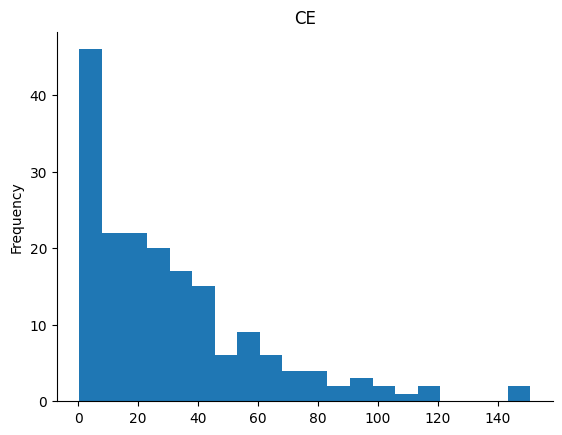

In [22]:
from matplotlib import pyplot as plt
training_vectors['CE'].plot(kind='hist', bins=20, title='CE')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
# find all unique values of training data names to use as classes
classes = training_vectors[['SAR']]
classes.shape

print(classes)

            SAR
0     26.926614
1     86.327645
2    112.754286
3    193.130080
4    126.060248
..          ...
178   65.786911
179  115.742116
180   77.180679
181   20.694501
182  107.606366

[183 rows x 1 columns]


In [26]:
# function to compute the IQR (upper and lower whisker)

def out_iqr(df , column):
    global loweriqr,upperiqr
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    loweriqr, upperiqr = q25 - cut_off, q75 + cut_off
    # print results
    print('IQR = ',iqr)
    print('lower whisker = ', round(loweriqr, 3))
    print('upper whisker = ', round(upperiqr, 3))
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upperiqr]
    df2 = df[df[column] < loweriqr]
    return print('Total number of outliers = ', df1.shape[0]+ df2.shape[0])

# Get the IQR limits ad the number of outliers
out_iqr(classes,'SAR')

IQR =  69.86348980930103
lower whisker =  -82.495
upper whisker =  196.959
Total number of outliers =  3


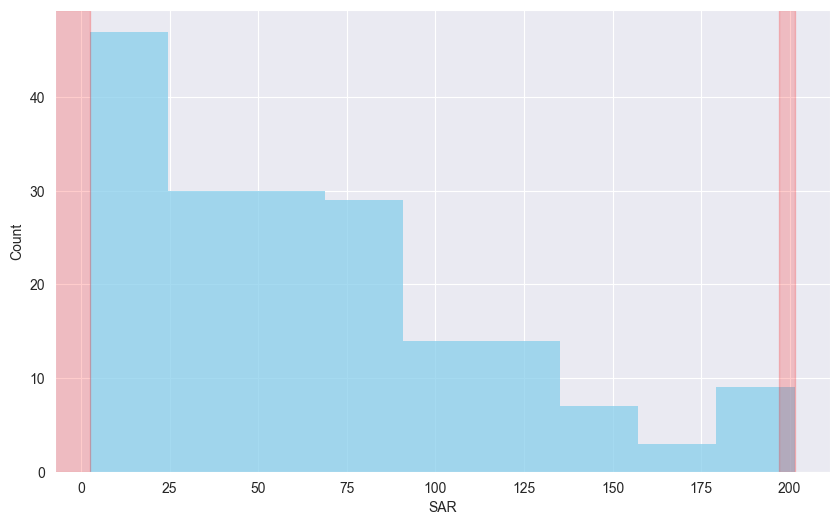

In [30]:
# histogram with areas defining outlier
plt.figure(figsize = (10,6))
sns.set_style('darkgrid') # set the background to grey with white tckmarks (ggplot default style)
sns.histplot(classes.SAR,
    color='skyblue',
    edgecolor='none'
    )
plt.axvspan(xmin= classes.SAR.min(), xmax = loweriqr, alpha=0.2, color='red') # lower was defined by the function 'out_iqr' produced above
plt.axvspan(xmin = upperiqr,xmax= classes.SAR.max(),alpha=0.2, color='red') # upper was defined by the function 'out_iqr' produced above
plt.show()

In [31]:
# To go back to matplotlib default style run:
plt.style.use('default')

In [35]:
# add a column to identify the IQR-based outliers
classes['Outlier_iqr'] = (classes['SAR'] < loweriqr) | (classes['SAR'] > upperiqr)
pd.crosstab(classes['Outlier_iqr'], columns='count')

col_0,count
Outlier_iqr,
False,180
True,3


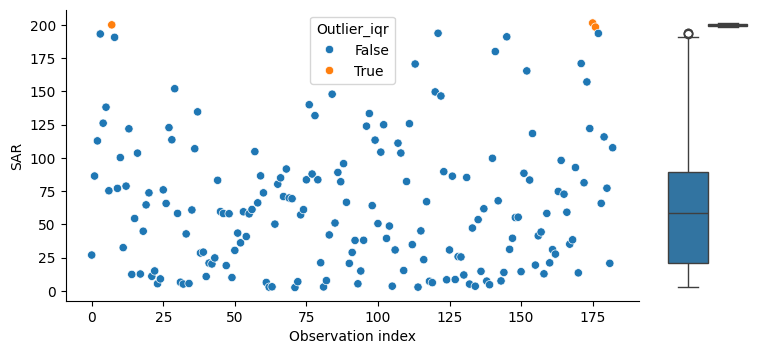

In [36]:
# Visualize the univariate ouliers of the dataset
g = sns.JointGrid(data=classes, x=classes.index, y='SAR', hue='Outlier_iqr')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='SAR')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid
plt.show()

In [39]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterstats.io import bounds_window

# Define the buffer distance (in raster units or coordinates)
buffer_distance = 6  # Adjust this distance as needed

##If you want to read the data directly from the shared folder, uncomment the following line.
raster_file = '../DataIn/PS_Index.tif'

# Create an empty list to store the buffered geometries
buffer_geoms = []
X_raw = []

with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.SAR, training_vectors.geometry):
        # Create a buffered geometry
        buffered_geom = geom.buffer(buffer_distance)

        # Add the buffered geometry to the list
        buffer_geoms.append(buffered_geom)

        # Get the bounds of the buffered geometry
        buffered_bounds = buffered_geom.bounds

        # Use the buffered bounds to create the window
        window = bounds_window(buffered_bounds, src.transform)

        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        mask = rasterize(
            [(buffered_geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='float32',
            all_touched=True
        ).astype(bool)
        label_pixels = np.argwhere(mask)

        buffer_values = []  # Lista para almacenar los valores de píxeles en el buffer
        for (row, col) in label_pixels:
            data = fsrc[:, row, col]
            one_x = np.nan_to_num(data, nan=0)
            buffer_values.append(one_x)

        # Calcular el valor promedio dentro del buffer
        if buffer_values:
            average_value = np.median(buffer_values, axis=0)
            X_raw.append(average_value)

# Create a GeoDataFrame from the list of buffered geometries
gdf = gpd.GeoDataFrame(geometry=buffer_geoms)

# Define the output shapefile path on Google Drive
output_shapefile = '../DataIntermediate/buffers.shp'

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_shapefile)

print("Archivos shapefile guardados con éxito en Google Drive.")

Archivos shapefile guardados con éxito en Google Drive.


### Make a corrplot to see the correlation of the different index's and SAR data

In [40]:
X = pd.DataFrame(X_raw, columns = ["NDVI", "SR", "GCVI", "NDWI", "VARI", "GNDVI", "GRVI", "SAVI", "VSSI", "S1", "S2", 
"S3_G1", "S3_G2", "S4", "S5_G1", "S5_G2", "S6_G1", "S6_G2", "SI", "NDSI", "SI1_G1", 
"SI1_G2", "SI2_G1", "SI2_G2", "SI3_G1", "SI3_G2", "Int1_G1", "Int1_G2", "Int2_G1", 
"Int2_G2", "YRS6_G1", "YRS6_G2", "RS6_G1", "RS6_G2", "RS1", "RS2", "RS3_G1", "RS3_G2", 
"RS4", "RS5_G1", "RS5_G2", "RNDSI", "RNDVI", "RSI", "RSI1_G1", "RSI1_G2", "RSI2_G1", 
"RSI2_G2", "RSI3_G1", "RSI3_G2", "RInt1_G1", "RInt1_G2", "RInt2_G1", "RInt2_G2", 
"YRS1", "YRS2", "YRS3_G1", "YRS3_G2", "YRS4", "YRS5_G1", "YRS5_G2", "YRSI", "YRSI1_G1", 
"YRSI1_G2", "YRSI2_G1", "YRSI2_G2", "YRSI3_G1", "YRSI3_G2", "YRInt1_G1", "YRInt1_G2", 
"YRInt2_G1", "YRInt2_G2", "YRNDSI", "YRNDVI", "YBS1", "YBS2", "YBS4", "YBS5_G1", 
"YBS5_G2", "YBSI", "YGS3", "YGSI1", "YGSI2", "YGSI3", "YGInt1", "YGInt2", "YNS6_G1", 
"YNS6_G2", "YNSI2_G1", "YNSI2_G2", "YNInt2_G1", "YNInt2_G2", "YNNDSI", "YNNDVI", "b1_1", 'b2_1', 'b3_1', 'b4_1']).dropna()
# X = pd.concat([X, coordinates[['x', 'y']]], axis=1)
y = pd.DataFrame(training_vectors[["SAR"]]).dropna()

(X.shape, y.shape)

((183, 98), (183, 1))

In [44]:
# Concatenar X y y a lo largo de las columnas (axis=1)
merged_df = pd.concat([X, y], axis=1)

# Exportar el DataFrame fusionado a un archivo xlsx
merged_df.to_csv('../DataIntermediate/merged_data_cafine.csv')

In [45]:
X_corr = X[["NDVI", "SR", "GCVI", "NDWI", "VARI", "GNDVI", "GRVI", "SAVI", "VSSI", "S1", "S2", 
"S3_G1", "S3_G2", "S4", "S5_G1", "S5_G2", "S6_G1", "S6_G2", "SI", "NDSI", "SI1_G1", 
"SI1_G2", "SI2_G1", "SI2_G2", "SI3_G1", "SI3_G2", "Int1_G1", "Int1_G2", "Int2_G1", 
"Int2_G2", "YRS6_G1", "YRS6_G2", "RS6_G1", "RS6_G2", "RS1", "RS2", "RS3_G1", "RS3_G2", 
"RS4", "RS5_G1", "RS5_G2", "RNDSI", "RNDVI", "RSI", "RSI1_G1", "RSI1_G2", "RSI2_G1", 
"RSI2_G2", "RSI3_G1", "RSI3_G2", "RInt1_G1", "RInt1_G2", "RInt2_G1", "RInt2_G2", 
"YRS1", "YRS2", "YRS3_G1", "YRS3_G2", "YRS4", "YRS5_G1", "YRS5_G2", "YRSI", "YRSI1_G1", 
"YRSI1_G2", "YRSI2_G1", "YRSI2_G2", "YRSI3_G1", "YRSI3_G2", "YRInt1_G1", "YRInt1_G2", 
"YRInt2_G1", "YRInt2_G2", "YRNDSI", "YRNDVI", "YBS1", "YBS2", "YBS4", "YBS5_G1", 
"YBS5_G2", "YBSI", "YGS3", "YGSI1", "YGSI2", "YGSI3", "YGInt1", "YGInt2", "YNS6_G1", 
"YNS6_G2", "YNSI2_G1", "YNSI2_G2", "YNInt2_G1", "YNInt2_G2", "YNNDSI", "YNNDVI", "b1_1", 'b2_1', 'b3_1', 'b4_1']]

X_corr.head()

,NDVI,SR,GCVI,NDWI,VARI,GNDVI,GRVI,SAVI,VSSI,S1,...,YNSI2_G1,YNSI2_G2,YNInt2_G1,YNInt2_G2,YNNDSI,YNNDVI,b1_1,b2_1,b3_1,b4_1
0,0.364127,2.145283,2.336546,-0.538803,-0.330611,0.538803,3.336546,0.242722,-19060.0,0.527442,...,2004.525879,2029.755371,1708.75,1740.25,0.031445,-0.031445,0.000000,0.000000,0.000000,0.000000
1,0.439585,2.568796,2.107235,-0.513050,-0.154374,0.513050,3.107235,0.293014,-15495.0,0.690148,...,1631.835571,1662.349121,1401.75,1432.25,-0.059287,0.059287,0.519413,0.473399,0.337389,0.181547
2,0.508677,3.070660,2.571547,-0.562505,-0.128842,0.562505,3.571547,0.339072,-16807.0,0.693402,...,1578.876099,1604.891113,1356.50,1383.25,-0.074180,0.074180,0.654887,0.343329,0.461192,0.192468
3,0.416839,2.429589,1.797036,-0.473273,-0.125389,0.473273,2.797036,0.277851,-15069.5,0.701602,...,1703.077148,1722.465576,1465.75,1484.50,-0.059602,0.059602,0.524789,0.470715,0.431571,0.093336
4,0.354755,2.100475,1.346602,-0.402379,-0.109266,0.402379,2.346602,0.236459,-11940.0,0.773585,...,1498.334961,1522.307861,1291.25,1314.25,-0.048999,0.048999,0.517816,0.474641,0.407218,0.110598


In [46]:
# Renombrar las columnas de 
# NOTA RELEVANTE sobre orden raster de textura de suelo caso Cafine:
# B1_1 = Clay + Silt
# B2_1 = Sand
# B3_1 = Silt
# B4_1 = Clay

X.rename(columns={
    'b1_1': 'Clay+Silt Raster',
    'b2_1': 'Sand Raster',
    'b3_1': 'Silt Raster',
    'b4_1': 'Clay Raster'
}, inplace=True)

In [47]:
y_corr = pd.DataFrame(y, columns=['SAR'])

In [49]:
datos_corr = pd.concat([y_corr,X], axis = 1)
datos_corr.head()

,SAR,NDVI,SR,GCVI,NDWI,VARI,GNDVI,GRVI,SAVI,VSSI,...,YNSI2_G1,YNSI2_G2,YNInt2_G1,YNInt2_G2,YNNDSI,YNNDVI,Clay+Silt Raster,Sand Raster,Silt Raster,Clay Raster
0,26.926614,0.364127,2.145283,2.336546,-0.538803,-0.330611,0.538803,3.336546,0.242722,-19060.0,...,2004.525879,2029.755371,1708.75,1740.25,0.031445,-0.031445,0.000000,0.000000,0.000000,0.000000
1,86.327645,0.439585,2.568796,2.107235,-0.513050,-0.154374,0.513050,3.107235,0.293014,-15495.0,...,1631.835571,1662.349121,1401.75,1432.25,-0.059287,0.059287,0.519413,0.473399,0.337389,0.181547
2,112.754286,0.508677,3.070660,2.571547,-0.562505,-0.128842,0.562505,3.571547,0.339072,-16807.0,...,1578.876099,1604.891113,1356.50,1383.25,-0.074180,0.074180,0.654887,0.343329,0.461192,0.192468
3,193.130080,0.416839,2.429589,1.797036,-0.473273,-0.125389,0.473273,2.797036,0.277851,-15069.5,...,1703.077148,1722.465576,1465.75,1484.50,-0.059602,0.059602,0.524789,0.470715,0.431571,0.093336
4,126.060248,0.354755,2.100475,1.346602,-0.402379,-0.109266,0.402379,2.346602,0.236459,-11940.0,...,1498.334961,1522.307861,1291.25,1314.25,-0.048999,0.048999,0.517816,0.474641,0.407218,0.110598


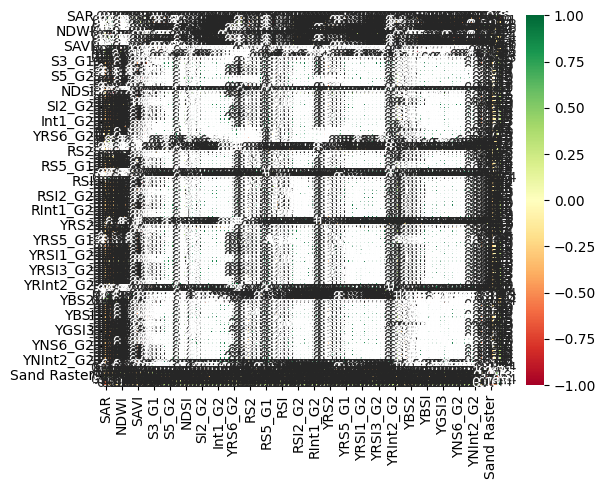

In [50]:
cormat = datos_corr.corr()

# Redondear la matriz de correlación a dos decimales
cormat_rounded = round(cormat, 2)

# Crear el gráfico
sns.heatmap(cormat_rounded, annot=True, fmt='.2f', cmap='RdYlGn')

# Mostrar el gráfico
plt.show()

In [52]:
# Obtener la correlación con la columna 'SAR' y ordenar por valor absoluto
correlaciones_sar = cormat['SAR'].abs().sort_values(ascending=False)

# Mostrar las 10 correlaciones más altas
# print("Las 10 correlaciones más altas con la columna 'SAR':")
corr_df = pd.DataFrame(correlaciones_sar)
corr_df.head(61)

,SAR
SAR,1.000000
Clay Raster,0.585879
YNNDSI,0.461668
YNNDVI,0.461668
YBS2,0.461668
...,...
YRInt2_G2,0.300022
YRSI3_G1,0.299755
RInt1_G1,0.299606
RSI2_G1,0.296694


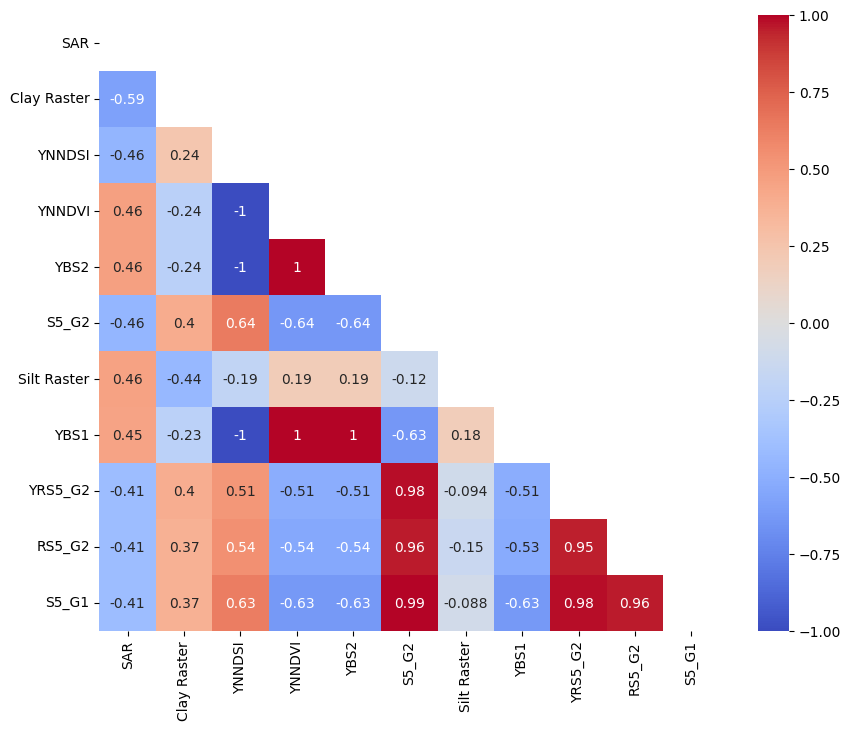

In [57]:
# Obtener la correlación con la columna 'SAR' y ordenar por valor absoluto
correlaciones_sar = cormat['SAR'].abs().sort_values(ascending=False)

# Seleccionar las 10 correlaciones más altas incluyendo 'SAR'
top_10_corr = correlaciones_sar.head(11).index

# Crear una matriz de correlación para las 10 variables más correlacionadas con 'SAR'
top_10_cormat = cormat.loc[top_10_corr, top_10_corr]

mask = np.triu(np.ones_like(top_10_cormat, dtype=bool))

# Plotear la matriz de correlación de las 10 variables más correlacionadas
plt.figure(figsize=(10, 8))
sns.heatmap(top_10_cormat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('')
plt.show()